In [22]:
import os
import cv2 as cv
import numpy as np
from skimage.io import imshow

from inspection.support.utils import cut, align, extract, highlight

# Setup


In [460]:
source_folder = (
    "/media/egor/T7/vut_dp_project_workspace/assets/datasets/custom_structured"
)
targets = [
    "34_drawcore_uc_16mm_f8_6448",
    "35_drawcore_uc_16mm_f8_5270",
    "36_drawcore_uc_16mm_f8_7604",
]

# Image to perform inspection against
template_original = cv.cvtColor(
    cv.imread("inspection/support/uc_camera/drawcore.bmp"),
    cv.COLOR_BGR2RGB,
)
# Image with marked places to control (image may be different from original for this test).
# Mask transfer will be performed
template_masked = cv.cvtColor(
    cv.imread("inspection/support/test_masks/drawcore.png"),
    cv.COLOR_BGR2RGB,
)
template_masked_original = cv.cvtColor(
    cv.imread("inspection/support/um_camera/drawcore.bmp"),
    cv.COLOR_RGB2GRAY,
)

extract_colors = [
    [np.array([255, 0, 0], np.uint8), True],  # RGB, Expect component
    [np.array([0, 255, 0], np.uint8), False],  # RGB, Expect no component
]

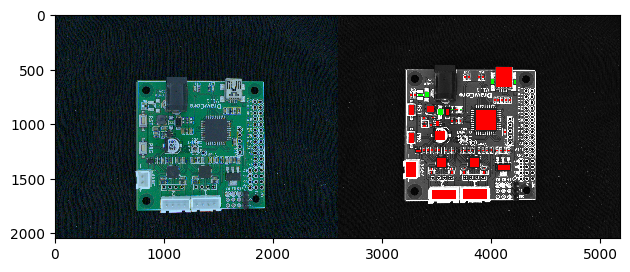

In [461]:
imshow(np.hstack([template_original, template_masked]))

# Remove background

Remove background from template image once and use coordinates to remove background from tested images after alignment.


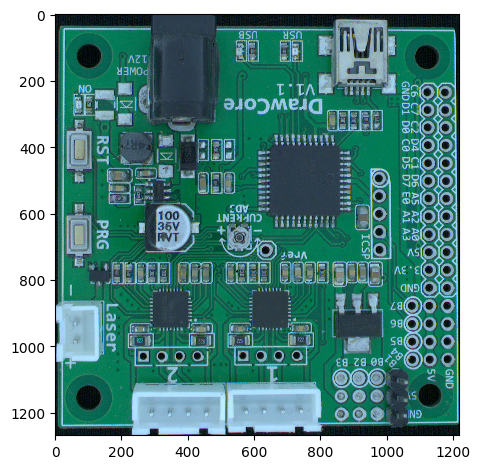

In [462]:
im = cv.cvtColor(template_original, cv.COLOR_RGB2GRAY)
im = align(im, template_masked_original)

# Blur to vanish texture defects
im = cv.medianBlur(im, 55)

# Arbitrary selected global threshold to separate background
val, im = cv.threshold(im, 40, 255, cv.THRESH_BINARY)

analysis = cv.connectedComponentsWithStats(im, cv.CV_32S)
(_, _, values, _) = analysis

# Select the biggest connected component (PCB desk)
mx, mxi = 0, 0
for i, value in enumerate(values):
    area = value[cv.CC_STAT_AREA]
    if area >= mx:
        mxi = i

REMOVE_BACKGROUND_VALUE = values[mxi]
im = cut(align(template_original, template_masked_original),
         REMOVE_BACKGROUND_VALUE)

imshow(im)

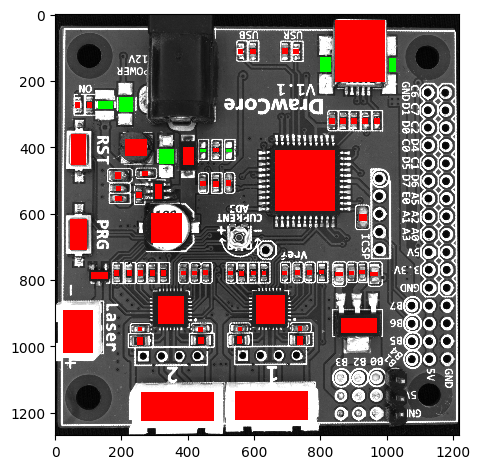

In [463]:
template_masked_reduced = cut(template_masked, REMOVE_BACKGROUND_VALUE)
imshow(template_masked_reduced)

# Mask transfer and control area selection

Select all masked components for accuracy tests. Store components them self (chunks), coordinates in tested image and label of chunk.


In [494]:
all_images = []  # [im1, im2, ...]
all_chunks = []  # [[chunk1, chunk2, ...], ...]
all_labels = []  # [[l1, l2, ...], ...]
all_values = []  # [[val1, val2, ...], ...]

for target in targets:
    # Walk different camera setups
    print(f"Processing: {target}")
    for f in os.listdir(f"{source_folder}/{target}"):
        # Load each image to perform inspection on
        tested_image = cv.cvtColor(
            cv.imread(f"{source_folder}/{target}/{f}"),
            cv.COLOR_BGR2RGB,
        )
        # Perform component location extraction
        im = align(tested_image, template_masked_original)
        im = cut(im, REMOVE_BACKGROUND_VALUE)
        all_images.append(im)

        im_um = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

        tmp_chunks = []
        tmp_labels = []
        tmp_values = []
        for color, lbl in extract_colors:
            _, values = extract(im_um, color, template_masked_reduced)
            tmp_values.extend(values)

            for value in values:
                tmp_chunks.append(cut(im, value))
                tmp_labels.append(f"{target}_{f}_{lbl}")
        all_values.append(tmp_values)
        all_chunks.append(tmp_chunks)
        all_labels.append(tmp_labels)

Processing: 34_drawcore_uc_16mm_f8_6448


Processing: 35_drawcore_uc_16mm_f8_5270
Processing: 36_drawcore_uc_16mm_f8_7604


# Component detection


## Histogram back projection


In [491]:
def back_projection(im: np.ndarray, bins: int, mask: np.ndarray = None):
    # Calculate histogram over cropped image (crop to offset * original width/hight) to minimize influence of
    # possible global background remainders
    ranges = [0, 180]
    hist_size = max(bins, 2)
    hist = cv.calcHist([im], [0], mask, [hist_size], ranges, accumulate=False)
    cv.normalize(hist, hist, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

    return cv.calcBackProject([im], [0], hist, ranges, scale=1)


def weighted_back_projection(im: np.ndarray, bins_lb, bins_ub, mask: np.ndarray = None):
    # Perform weighted histogram back projection
    hsv = cv.cvtColor(im, cv.COLOR_RGB2HSV)
    im = np.empty(hsv.shape, hsv.dtype)
    cv.mixChannels([hsv], [im], (0, 0))

    # Weight is just inversion of bin size
    im_hbp = back_projection(im, bins_lb, mask).astype(float)
    for bins in range(bins_lb + 1, bins_ub):
        im_hbp += (1 / bins) * back_projection(im, bins)

    return (im_hbp / im_hbp.max() * 255).astype(np.uint8)


def is_component_present(
    im: np.ndarray,
    chunk_values: list[list[int]],
    bins_lb: int = 5,
    bins_ub: int = 45,
    background_assignment_probability: float = 0.8,
    least_allowed_component_to_background_ratio: float = 0.6,
    noise_reduction_kernel_size: int = 3,
):
    # Perform missing component inspection using histogram back projection method. Function expect aligned cropped images.
    test_image_hbp = weighted_back_projection(im, bins_lb, bins_ub)

    results = []
    for value in chunk_values:
        test_component_hbp = cut(test_image_hbp, value)
        test_component_mask = test_component_hbp < (
            255 * background_assignment_probability
        )

        test_component_mask = cv.medianBlur(
            test_component_mask.astype(np.uint8), noise_reduction_kernel_size
        )

        ratio = test_component_mask.sum() / test_component_mask.size
        test = ratio >= least_allowed_component_to_background_ratio

        # Return true as mark of a present component
        results.append([test, test_component_mask])
    return results

### Manual setting


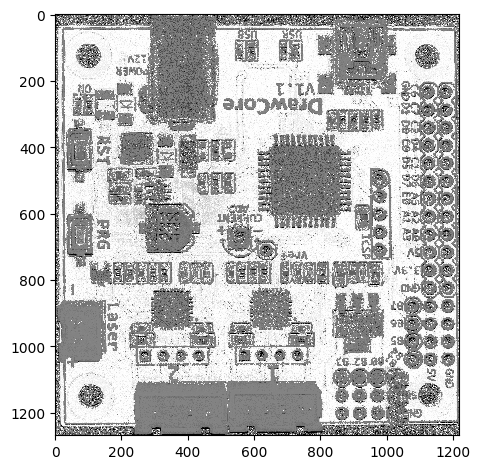

In [503]:
test_image = all_images[20]
test_values = all_values[20]
test_labels = all_labels[20]
test_hbp = weighted_back_projection(test_image, 1, 35)

# template_image = align(template_original, template_masked_original)
# template_image = cut(template_image, REMOVE_BACKGROUND_VALUE)

imshow(test_hbp)

In [498]:
inspection = is_component_present(
    test_image,
    test_values,
    bins_ub=35,
    background_assignment_probability=0.85,
    least_allowed_component_to_background_ratio=0.85,
    noise_reduction_kernel_size=3,
)
print(
    "\n".join(
        [
            f"{i}. {lbl}: {res}"
            for i, ([res, _], lbl) in enumerate(zip(inspection, test_labels))
        ]
    )
)

0. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
1. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
2. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
3. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
4. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
5. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
6. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
7. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
8. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
9. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
10. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
11. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
12. 34_drawcore_uc_16mm_f8_6448_Image__2024-02-27__10-22-41.bmp_True: True
13. 34_drawcore_uc_16mm_f8_6448_Ima

### Inspection quality evaluation


In [501]:
all_inspections = []
for test_image, test_value in zip(all_images, all_labels):
    inspection = is_component_present(
        test_image,
        test_values,
        bins_ub=35,
        background_assignment_probability=0.85,
        least_allowed_component_to_background_ratio=0.85,
    )
    all_inspections.append(inspection)

In [505]:
failed = []
for inspection, labels, im, chunks, values in zip(
    all_inspections, all_labels, all_images, all_chunks, all_values
):
    for chunk_inspection, label, chunk, value in zip(
        inspection, labels, chunks, values
    ):
        result = chunk_inspection[0]
        result_mask = chunk_inspection[1]

        if str(result) not in label:
            ratio = result_mask.sum() / result_mask.size
            print(f"[{label}] ratio: {ratio}")
            
            failed.append(
                [result, result_mask, ratio, label, chunk, value, im, labels, values]
            )

[36_drawcore_uc_16mm_f8_7604_Image__2024-02-27__10-25-52.bmp_True] ratio: 0.7692307692307693
[36_drawcore_uc_16mm_f8_7604_Image__2024-02-27__10-26-05.bmp_True] ratio: 0.841025641025641


[36_drawcore_uc_16mm_f8_7604_Image__2024-02-27__10-25-52.bmp_True] ratio: 0.7692307692307693


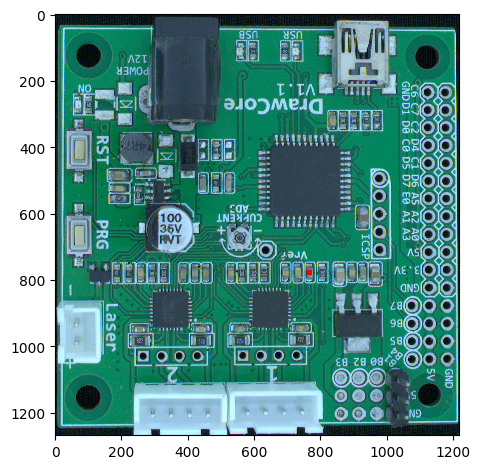

In [509]:
result, result_mask, ratio, label, chunk, value, im, labels, values = failed[0]
print(f"[{label}] ratio: {ratio}")

imshow(highlight(im, value, [255, 0, 0]))